In [97]:
#import librarries
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
#import data and display first 5 records
df = pd.read_csv('../data/raw/churn.csv')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## DATA CLEANING

In [99]:
#check data type of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [100]:
#check for missing values
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

### Check and drop columns that may not be useful

In [101]:
#visualize columns
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [102]:
# Count has only one unique value and won't be useful for prediction
df['Count'].nunique()

1

In [103]:
# Country has only one unique value and won't be useful for prediction
df['Country'].nunique()

1

In [104]:
# State has only one unique value and won't be useful for prediction
df['State'].nunique()

1

In [105]:
# Every customer (column) has unique value for CustomerID hence CustomerID column won't be useful for preduction
df['CustomerID'].nunique()

7043

In [106]:
# City (column) has too many unique values
df['City'].nunique()

1129

In [107]:
#too many unique values
df['CLTV'].nunique()

3438

In [14]:
df.drop(['Churn Label','Churn Score', 'CLTV', 'Churn Reason',
        'Count', 'Country', 'State', 'CustomerID', 'Lat Long','City'], axis = 1, inplace = True)

In [15]:
df.head(5)

,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [21]:
#It was observed that some columns have whitespaces
df.columns

Index(['Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')

In [22]:
#remove whitespaces from columns
df.columns = df.columns.str.replace(' ', '_')

#### Observe that the Total_Charges column have an innapropriate datatype (object). This typically happens when a supposedly numeric column has some non numeric values. Trying to convert the Total_Charges to numeric column usins df['Total_Charges'] = pd.to_numeric(df['Total_Charges']) threw an error saying "Unable to parse string at position 2234", hence I checked the value at row 2234

In [23]:
#empty space obserce row 2234
df['Total_Charges'].iloc[2233:2236]

2233    6201.95
2234           
2235    6597.25
Name: Total_Charges, dtype: object

In [30]:
#there are 11 missing vlaues (empty spaces) in the Total_Charges column
len(df.loc[df['Total_Charges']==" "]['Total_Charges'])

11

In [31]:
# visualize the empty values in the Total_Charges column. Observe the Total_Charges column
df.loc[df['Total_Charges']==" "]

,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


### Most likely, the customers (rows) involved are newly subscribed customers who have not been charged. Also, observe that their Churn_Value are all zero meaning that the 11 customers had not left. I shall resolve this by setting the emptytotal_Charges to zero

In [32]:
#set all empty spaces to zero
df.loc[(df['Total_Charges']==" "),'Total_Charges']= 0

In [33]:
#change column data type to numeric (float)
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

In [34]:
df['Total_Charges'].dtypes

dtype('float64')

In [35]:
#convert all empty spaces in non numeric column to _
df.replace(' ', '_', regex=True, inplace=True)

# EXPLORATORY DATA ANALYSIS

<AxesSubplot: xlabel='Churn_Value', ylabel='count'>

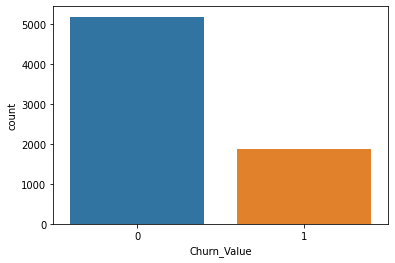

In [91]:
#dataset slightly imbalanced
sns.countplot(x = 'Churn_Value', data = df)

In [92]:
#correlation of each of the variables with fraud
df.corr()['Churn_Value'].sort_values()

Tenure_Months     -0.352229
Total_Charges     -0.198324
Latitude          -0.003384
Zip_Code           0.003346
Longitude          0.004594
Monthly_Charges    0.193356
Churn_Value        1.000000
Name: Churn_Value, dtype: float64

Exploraing the distribution of the variables with significant correlation with the target variable

<AxesSubplot: xlabel='Churn_Value', ylabel='Tenure_Months'>

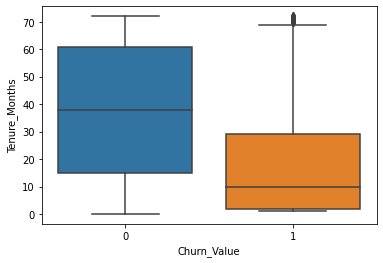

In [93]:
sns.boxplot(x='Churn_Value',y='Tenure_Months',data=df)

<AxesSubplot: xlabel='Churn_Value', ylabel='Total_Charges'>

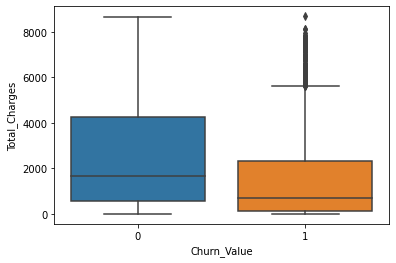

In [94]:
sns.boxplot(x='Churn_Value',y='Total_Charges',data=df)

<AxesSubplot: xlabel='Churn_Value', ylabel='Monthly_Charges'>

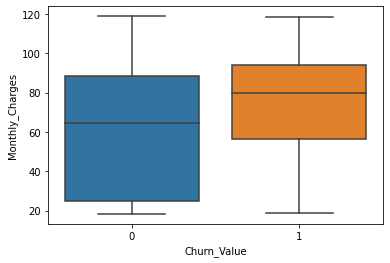

In [95]:
sns.boxplot(x='Churn_Value',y='Monthly_Charges',data=df)

# DATA PREPROCESSING

In [46]:
X = df.drop('Churn_Value',axis=1)
y = df['Churn_Value']

In [47]:
#oberser oject, integer and float datatype
X.dtypes

Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [48]:
#convert categorical variables to dummy variables
X = pd.get_dummies(X, columns = ['Gender',
                                'Senior_Citizen',
                                'Partner',
                                'Dependents',
                                'Phone_Service',
                                'Multiple_Lines',
                                'Internet_Service',
                                'Online_Security',
                                'Online_Backup',
                                'Device_Protection',
                                'Tech_Support',
                                'Streaming_TV',
                                'Streaming_Movies',
                                'Contract',
                                'Paperless_Billing',
                                'Payment_Method'
                                         
    
],drop_first=True)
X.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Gender_Male,Senior_Citizen_Yes,Partner_Yes,Dependents_Yes,...,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_One_year,Contract_Two_year,Paperless_Billing_Yes,Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,1,...,0,1,0,1,0,0,1,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,1,1,...,0,1,0,1,0,0,1,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0


In [49]:
X.columns

Index(['Zip_Code', 'Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges',
       'Total_Charges', 'Gender_Male', 'Senior_Citizen_Yes', 'Partner_Yes',
       'Dependents_Yes', 'Phone_Service_Yes',
       'Multiple_Lines_No_phone_service', 'Multiple_Lines_Yes',
       'Internet_Service_Fiber_optic', 'Internet_Service_No',
       'Online_Security_No_internet_service', 'Online_Security_Yes',
       'Online_Backup_No_internet_service', 'Online_Backup_Yes',
       'Device_Protection_No_internet_service', 'Device_Protection_Yes',
       'Tech_Support_No_internet_service', 'Tech_Support_Yes',
       'Streaming_TV_No_internet_service', 'Streaming_TV_Yes',
       'Streaming_Movies_No_internet_service', 'Streaming_Movies_Yes',
       'Contract_One_year', 'Contract_Two_year', 'Paperless_Billing_Yes',
       'Payment_Method_Credit_card_(automatic)',
       'Payment_Method_Electronic_check', 'Payment_Method_Mailed_check'],
      dtype='object')

In [51]:
X.columns = columns = ['Zip_Code', 'Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges',
       'Total_Charges', 'Gender_Male', 'Senior_Citizen_Yes', 'Partner_Yes',
       'Dependents_Yes', 'Phone_Service_Yes',
       'Multiple_Lines_No_phone_service', 'Multiple_Lines_Yes',
       'Internet_Service_Fiber_optic', 'Internet_Service_No',
       'Online_Security_No_internet_service', 'Online_Security_Yes',
       'Online_Backup_No_internet_service', 'Online_Backup_Yes',
       'Device_Protection_No_internet_service', 'Device_Protection_Yes',
       'Tech_Support_No_internet_service', 'Tech_Support_Yes',
       'Streaming_TV_No_internet_service', 'Streaming_TV_Yes',
       'Streaming_Movies_No_internet_service', 'Streaming_Movies_Yes',
       'Contract_One_year', 'Contract_Two_year', 'Paperless_Billing_Yes',
       'Payment_Method_Credit_card_automatic',
       'Payment_Method_Electronic_check', 'Payment_Method_Mailed_check']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [53]:
sum(y_train)/len(y_train)

0.2654297614539947

In [54]:
sum(y_test)/len(y_test)

0.26519023282226006

# MODEL TRAINING

In [57]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.63387
[1]	validation_0-aucpr:0.64205
[2]	validation_0-aucpr:0.64642
[3]	validation_0-aucpr:0.64800
[4]	validation_0-aucpr:0.64770
[5]	validation_0-aucpr:0.65611
[6]	validation_0-aucpr:0.65868
[7]	validation_0-aucpr:0.65631
[8]	validation_0-aucpr:0.65654
[9]	validation_0-aucpr:0.65949
[10]	validation_0-aucpr:0.65913
[11]	validation_0-aucpr:0.65915
[12]	validation_0-aucpr:0.66051
[13]	validation_0-aucpr:0.65935
[14]	validation_0-aucpr:0.65907
[15]	validation_0-aucpr:0.65575
[16]	validation_0-aucpr:0.65635
[17]	validation_0-aucpr:0.65697
[18]	validation_0-aucpr:0.65577
[19]	validation_0-aucpr:0.65248
[20]	validation_0-aucpr:0.65273
[21]	validation_0-aucpr:0.65311


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=0, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


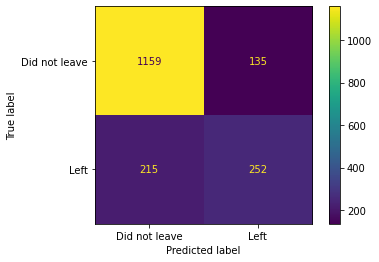

In [58]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not leave","Left"])

In [59]:
1159/(1159+135)

0.8956723338485317

In [60]:
252/(215+252)

0.5396145610278372

90% of the customers who stayed were correctly classified while only 54% of Churns were correctly predicted. This is not a good performance. Observe that the model was trained mostly with default parameters. I shall now carry out hyperparameter tunning using the GridSearchCV as well as panalizing wrong prediction of Churn using the scale_pos_weight parameter to see how much the performance will improve, especially in predicting the rare case which is of interest.

In [61]:
param_grid = {
    "max_depth":[3,4,5],
    "learning_rate":[0.1,0.01,0.05],
    "gamma":[0,0.25,1.0],
    "reg_lambda":[0,1.0,10.0],
}

In [62]:
optima_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective="binary:logistic",
                                    use_label_encoder=False,
                                    seed=42,
                                    subsample=0.9,
                                    colsample_bytree=0.5),
    param_grid=param_grid,
    scoring="roc_auc",
    verbose=0,
    n_jobs=10,
    cv=3
)

In [63]:
optima_params.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric="auc",
                  eval_set=[(X_test,y_test)],
                  verbose=False
)
print(optima_params.best_params_)

C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0}


I shall adjust the hyperparameters for the parameter that the extreme values were chosen to be optimal. This is because the optima parameter values may be outside the earlier chosen range.

In [66]:
para_grid = {
    "max_depth":[2,3,4],
    "learning_rate":[0.01,0.05,0.1,0.5,1],
    "gamma":[0],
    "reg_lambda":[10.0,20,100],
}

In [67]:
optima_params.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric="auc",
                  eval_set=[(X_test,y_test)],
                  verbose=False
)
print(optima_params.best_params_)

C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0}


No more change observed hence the optimal parameter established. However, since interest is in predicting churn, I shall fix the "scale_pos_weight" at 3 (that is sum(stay)/sum(Leave) to penalize the model for misclassifying the rare class (churn)

In [69]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            use_label_encoder=False,
                            missing=0)
                          
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.46253
[1]	validation_0-aucpr:0.53389
[2]	validation_0-aucpr:0.56821
[3]	validation_0-aucpr:0.57160
[4]	validation_0-aucpr:0.60707
[5]	validation_0-aucpr:0.61847
[6]	validation_0-aucpr:0.62476
[7]	validation_0-aucpr:0.62902
[8]	validation_0-aucpr:0.63201
[9]	validation_0-aucpr:0.63414
[10]	validation_0-aucpr:0.63197
[11]	validation_0-aucpr:0.63257
[12]	validation_0-aucpr:0.63385
[13]	validation_0-aucpr:0.63373
[14]	validation_0-aucpr:0.65053
[15]	validation_0-aucpr:0.64948
[16]	validation_0-aucpr:0.64940
[17]	validation_0-aucpr:0.65541
[18]	validation_0-aucpr:0.65655
[19]	validation_0-aucpr:0.65827
[20]	validation_0-aucpr:0.65835
[21]	validation_0-aucpr:0.65803
[22]	validation_0-aucpr:0.65815
[23]	validation_0-aucpr:0.66057
[24]	validation_0-aucpr:0.66059
[25]	validation_0-aucpr:0.66095
[26]	validation_0-aucpr:0.65946
[27]	validation_0-aucpr:0.65655
[28]	validation_0-aucpr:0.65734
[29]	validation_0-aucpr:0.65883
[30]	validation_0-aucpr:0.66042
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=0, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=10, ...)

# MODEL EVALUATION AND ASSESSMENT

C:\Users\HP 1O3O G2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


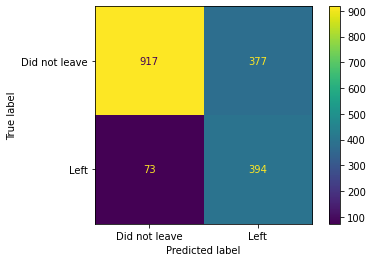

In [70]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not leave","Left"])

In [71]:
predictions = clf_xgb.predict(X_test)

In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.71      0.80      1294
           1       0.51      0.84      0.64       467

    accuracy                           0.74      1761
   macro avg       0.72      0.78      0.72      1761
weighted avg       0.82      0.74      0.76      1761



In [109]:
balanced_accuracy_score(y_test,predictions)

0.776169207907357

In [110]:
f1_score(y_test,predictions)

0.6365105008077544

In [112]:
roc_auc_score(y_test,predictions)

0.776169207907357

In [113]:
precision_score(y_test,predictions)

0.5110246433203631

In [114]:
recall_score(y_test,predictions)

0.8436830835117773

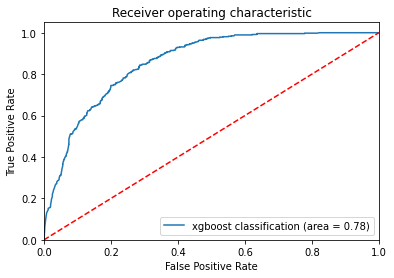

In [82]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y_test, clf_xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgboost classification (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('xgb_ROC')
plt.show()

In [83]:
917/(917+377)

0.7086553323029366

In [84]:
394/(394+73)

0.8436830835117773

Now, 84% of customer churn are correctly predicted. This is at the expense of reduction in percentateg of correct prediction of the customers who did not leave from 90% to 71%. This is a far better result because interest is on retaining customers that are expected to churn. The implication is that extra resouces may be expended in trying to retain customers who are wrongly predicted be among those the will leave but this is a far better option as the extra resources may even encurage those customers to increase their patronage. 

# DECISION TREE CONSTRUCTION

In [85]:
bst=clf_xgb.get_booster()
for importance_type in ('weight','gain','cover','total_gain','total_cover'):
    print('%s: ' %importance_type, bst.get_score(importance_type=importance_type))
    
node_params={'shape':'box',
            'style':'filled',
            'fillcolor':'#78cbe'}
leaf_params={'shape':'box',
            'style':'filled',
            'fillcolor':'#e48038'}

weight:  {'Zip_Code': 17.0, 'Latitude': 5.0, 'Longitude': 13.0, 'Tenure_Months': 31.0, 'Monthly_Charges': 22.0, 'Total_Charges': 20.0, 'Senior_Citizen_Yes': 1.0, 'Partner_Yes': 5.0, 'Dependents_Yes': 23.0, 'Phone_Service_Yes': 1.0, 'Multiple_Lines_No_phone_service': 1.0, 'Multiple_Lines_Yes': 1.0, 'Internet_Service_Fiber_optic': 20.0, 'Internet_Service_No': 9.0, 'Online_Security_No_internet_service': 2.0, 'Online_Security_Yes': 7.0, 'Online_Backup_No_internet_service': 3.0, 'Online_Backup_Yes': 1.0, 'Device_Protection_No_internet_service': 1.0, 'Tech_Support_Yes': 6.0, 'Streaming_TV_Yes': 4.0, 'Streaming_Movies_Yes': 5.0, 'Contract_One_year': 10.0, 'Contract_Two_year': 16.0, 'Paperless_Billing_Yes': 10.0, 'Payment_Method_Electronic_check': 11.0}
gain:  {'Zip_Code': 19.263622283935547, 'Latitude': 4.795428276062012, 'Longitude': 5.658805847167969, 'Tenure_Months': 91.39815521240234, 'Monthly_Charges': 33.18498611450195, 'Total_Charges': 51.91971969604492, 'Senior_Citizen_Yes': 3.8018798

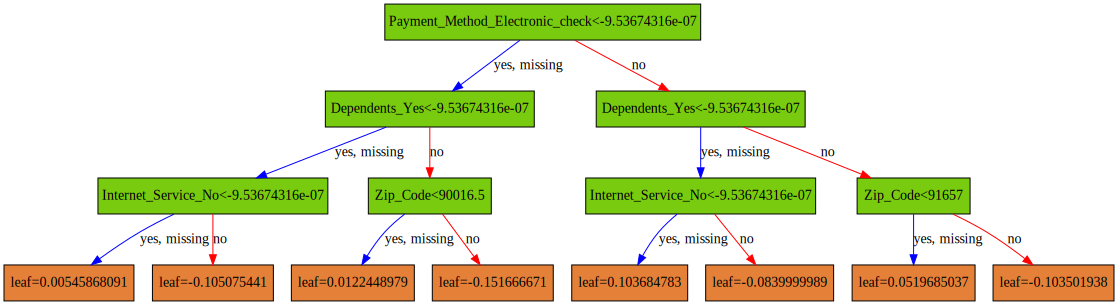

In [86]:
xgb.to_graphviz(clf_xgb,num_trees=0,size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)